In [1]:
import os
import sys
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from pathlib import Path
import numpy as np
import PIL
import PIL.Image
import json
from tqdm.auto import tqdm

#change working directory to root
ROOT_DIR = os.getcwd()
while os.path.basename(ROOT_DIR) != 'VisIrNet':
    ROOT_DIR = os.path.abspath(os.path.join(ROOT_DIR,'..'))
sys.path.insert(0,ROOT_DIR)
os.chdir(ROOT_DIR)

ROOT_DIR = Path(ROOT_DIR)

print(tf.__version__)
devices = tf.config.list_physical_devices('GPU')
print("len(devices): ", len(devices))
print(f"available GPUs: {devices}");


/home/nalain/miniconda3/envs/VisIrNet/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.14.0
len(devices):  1
available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
## gpu setup 
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
###

1 Physical GPUs, 1 Logical GPUs


**Configurations**

In [3]:
# config file to load will be passed as an argument
# get run parameters

import argparse 

parser = argparse.ArgumentParser()
parser.add_argument('--config-file', 
                        action = "store", 
                        dest = "config_file",
                        default = "vedai_default_config.json",
                        help = 'specify config file to load')

input_arguments = parser.parse_args([])

from Tools.configurations_parser import ConfigurationParser
# load configurations
configs = ConfigurationParser.getConfigurations(configs_path = 'configs', 
                                                config_file = str(input_arguments.config_file))


# print configurations
# ConfigurationParser.printConfigurations(configs)


[INFO] reading configurations from configs/vedai_default_config.json


**Dataloaders**

In [4]:
import data_setup

train_dataloader,test_dataloader = data_setup.create_dataloaders(dataset=configs.dataset, 
                                                                BATCH_SIZE=configs.BATCH_SIZE,
                                                                SHUFFLE_BUFFER_SIZE=configs.SHUFFLE_BUFFER_SIZE
                                                                )

len(train_dataloader), len(test_dataloader)
#

[INFO] loading train dataset
[INFO] train _dataset:  8722
[INFO] loading val dataset
[INFO] val _dataset:  3738
dataset: VEDAI
BATCH_SIZE: 2
SHUFFLE_BUFFER_SIZE: 1000
train_dataloader: 4361
test_dataloader: 1869


(4361, 1869)

## **Model**

In [5]:
#in this case load the existing model

In [6]:
import model_setup
import Utils

# featureEmbeddingBackBone = model_setup.getFeatureEmbeddingBackBone(rgb_inputs_shape=configs.RGB_INPUTS_SHAPE,
#                                                         ir_inputs_shape=configs.IR_INPUTS_SHAPE,
#                                                         output_channels_per_block=configs.OUTPUT_CHANNELS_PER_BLOCK,
#                                                         blocks_count=configs.B_STACK_COUNT,
#                                                         )

# regressionHead= model_setup.getRegressionHead(input_shape=configs.REGRESSION_INPUT_SHAPE,
#                                                 output_size=configs.REGRESSION_OUTPUT_SHAPE,
#                                                 blocks_count=configs.R_STACK_COUNT,
#                                                 )




In [76]:
## model name to load

import Tools.utilities as common_utils

from_checkpoint = "featureEmbeddingBackBone-e5db81738fea46239d8dd4cd5a0724fa-1.keras"
save_path = "models/VEDAI"

pattern = f"*featureEmbeddingBackBone*" if str(from_checkpoint)=="latest" else f"{from_checkpoint}*"
model_name = common_utils.latest_file(Path(save_path), pattern=pattern)

# log_tag["resumed_from"] = str(model_name)
model = common_utils.load_model(model_name)

[INFO] loading model from models/VEDAI/featureEmbeddingBackBone-e5db81738fea46239d8dd4cd5a0724fa-1.keras


## **Forward Pass**


In [27]:
input_images, template_images, labels,_instances = next(iter(train_dataloader))

In [77]:
import Tools.loss_functions as loss_functions
import Tools.datasetTools as DatasetTools


In [78]:

gt_matrix = DatasetTools.get_ground_truth_homographies(labels)
warped_inputs, _ = DatasetTools._get_warped_sampled(images = input_images,  homography_matrices = gt_matrix)


In [79]:

rgb_fmaps , ir_fmaps = model.call((input_images, template_images), training=False)


In [80]:


warped_fmaps,_ = DatasetTools._get_warped_sampled( images = rgb_fmaps, 
                                                    homography_matrices = gt_matrix)



In [81]:
total_loss , detailed_batch_losses = loss_functions.get_losses_febackbone( warped_inputs,
                                                                            template_images,
                                                                            warped_fmaps,
                                                                            ir_fmaps)



**Visualize All**

/tmp/ipykernel_14181/1045574588.py:32: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


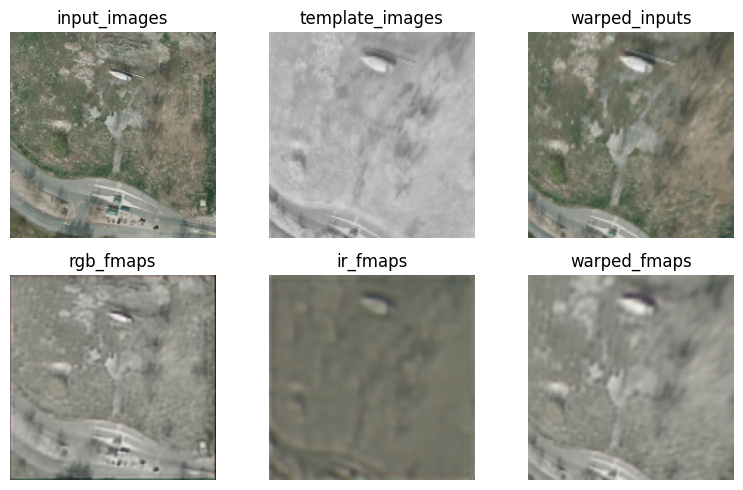

In [82]:
## 

import matplotlib.pyplot as plt

#"input_images", "rgb_fmaps", "template_images", "ir_fmaps", "warped_inputs","warped_fmaps" on a grid

# data_to_plot = {input_images[0], rgb_fmaps[0], template_images[0], ir_fmaps[0], warped_inputs[0], warped_fmaps[0]}
data_to_plot = {
    0:input_images,
    1:template_images,
    2:warped_inputs,
    3:rgb_fmaps,
    4:ir_fmaps,
    5:warped_fmaps,
                }

data_to_plot = {k:np.array(v[0]).clip(0,255) for k,v in data_to_plot.items()}
fig, axs = plt.subplots(2, 3, figsize=(8, 5), constrained_layout=True)
axs = axs.ravel()

# fig = plt.figure(figsize=(20, 20))
# axs = fig.subplots(3, 2)
titles=["input_images","template_images","warped_inputs","rgb_fmaps","ir_fmaps","warped_fmaps"]
for i, ax in enumerate(axs):
    ax.axis('off')
    ax.set_title(titles[i])
    pass


for i, data_i in enumerate(data_to_plot.values()):
    axs[i].imshow(data_i)
fig.tight_layout()
plt.show()
    


In [83]:
# print losses 

detailed_batch_losses = {str(i): k.numpy() for i, k in detailed_batch_losses.items()}
loss_message = " | ".join([str(str(i)+ " : " + str(k)) for i,k in detailed_batch_losses.items()])

In [84]:
warped_inputs_fmaps_sum = 0.5 *( warped_inputs[0]+warped_fmaps[0])
template_images_ir_fmaps_sum = 0.5 * (template_images[0] + tf.cast(ir_fmaps[0],tf.float32))

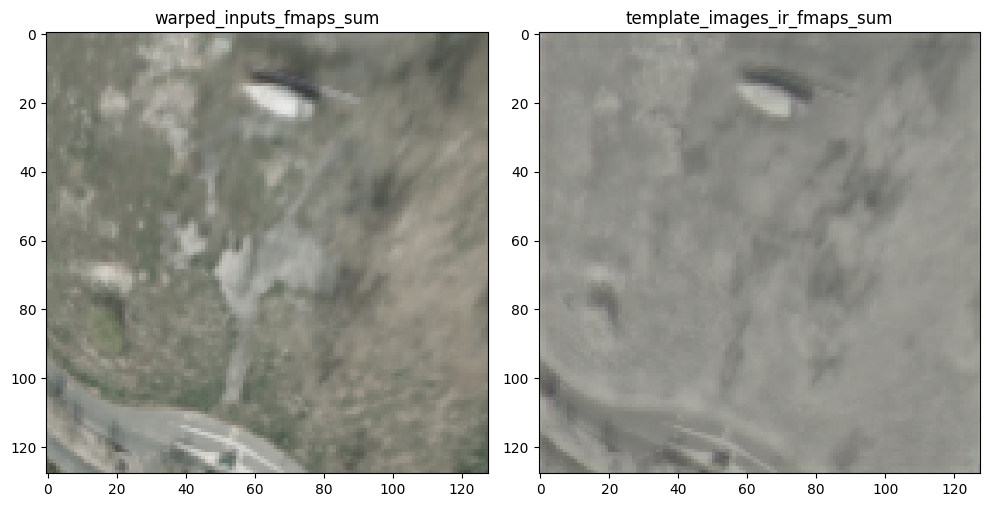

In [85]:
fig ,axes = plt.subplots(1,2,figsize=(10,10))
axes[0].set_title("warped_inputs_fmaps_sum")
axes[1].set_title("template_images_ir_fmaps_sum")
axes[0].imshow(warped_inputs_fmaps_sum)
axes[1].imshow(template_images_ir_fmaps_sum)
fig.tight_layout()
plt.show()
